# Gamma Regression (Boston Housing Data)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/docs/examples/Gamma_Regression_BostonHousing.ipynb)

# Imports

In [2]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gamma import *

from sklearn import datasets
from sklearn.model_selection import train_test_split

# Data

In [3]:
housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution Selection

In [4]:
# Specifies Gamma distribution with exp response function and option to stabilize Gradient/Hessian. Type ?Gamma for an overview.
lgblss = LightGBMLSS(
    Gamma(stabilization="L2",     # Options are "None", "MAD", "L2".
          response_fn="softplus", # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
          loss_fn="nll"           # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
         )
)

# Hyper-Parameter Optimization

Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

In [5]:
param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=20,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=30,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-08-11 12:29:16,191] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-08-11 12:29:30,946] Trial 0 finished with value: 3655.994319219647 and parameters: {'eta': 0.0055601230544869195, 'max_depth': 7, 'subsample': 0.9477091024240025, 'feature_fraction': 0.9480677544137415, 'boosting': 'gbdt'}. Best is trial 0 with value: 3655.994319219647.
[I 2023-08-11 12:29:43,746] Trial 1 finished with value: 4227.673235529888 and parameters: {'eta': 0.0023020600298896826, 'max_depth': 4, 'subsample': 0.8651585394401682, 'feature_fraction': 0.8334419259540924, 'boosting': 'gbdt'}. Best is trial 0 with value: 3655.994319219647.
[I 2023-08-11 12:29:56,252] Trial 2 finished with value: 4339.068493424474 and parameters: {'eta': 0.0027858552626389625, 'max_depth': 4, 'subsample': 0.7481047090926836, 'feature_fraction': 0.28093366785144963, 'boosting': 'gbdt'}. Best is trial 0 with value: 3655.994319219647.
[I 2023-08-11 12:30:09,051] Trial 3 finished with value: 4654.563387175151 and parameters: {'eta': 0.000444156259151128, 'max_depth': 3, 'subsample': 0.6107418507

# Model Training

In [6]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [7]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [8]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.803845,2.055054,3.721187,2.103017,2.785087,1.427447,2.607677,1.835255,2.056286,1.429045,...,1.519037,1.412902,1.625722,1.990941,1.041016,1.458764,2.493577,2.022398,2.520749,1.871148
1,0.955117,0.304340,0.505187,0.712550,1.216954,0.933732,0.380238,1.482657,0.736652,0.427856,...,1.171600,1.010972,0.735717,1.319169,1.202447,0.967412,0.966288,1.435245,0.821253,0.793779
2,1.144286,3.009341,1.845451,3.251571,2.020669,1.400807,2.169500,1.314221,1.898889,1.066060,...,1.997797,1.747813,2.150669,2.500485,1.338773,1.857834,1.787327,1.801178,2.843899,1.567025
3,1.808418,3.125320,1.761757,1.979179,2.679116,1.515085,1.274946,1.122176,2.836676,2.317276,...,1.435263,1.846332,1.362321,1.321298,1.959441,1.562435,1.587221,1.903269,1.783693,1.171151
4,4.249149,3.424617,3.813255,3.438753,2.999937,3.809508,3.346083,2.839856,3.459303,3.179483,...,3.772136,3.544357,3.080696,6.813697,4.206345,2.519868,3.878748,5.277604,4.116862,3.673533


In [9]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,1.104986,2.876080
1,0.493789,1.469833
2,0.998464,2.626445
3,1.021038,2.662356
4,2.412530,5.914484


In [10]:
pred_params.head()

,concentration,rate
0,12.671469,6.625142
1,9.840599,10.347679
2,12.215254,7.179342
3,11.811074,6.747012
4,13.350488,3.346810


# SHAP Interpretability

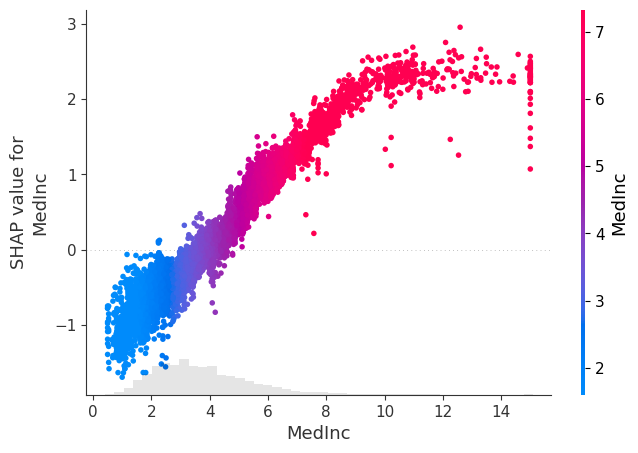

In [11]:
# Partial Dependence Plot
shap_df = pd.DataFrame(X_train, columns=feature_names)

lgblss.plot(shap_df,
            parameter="concentration",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

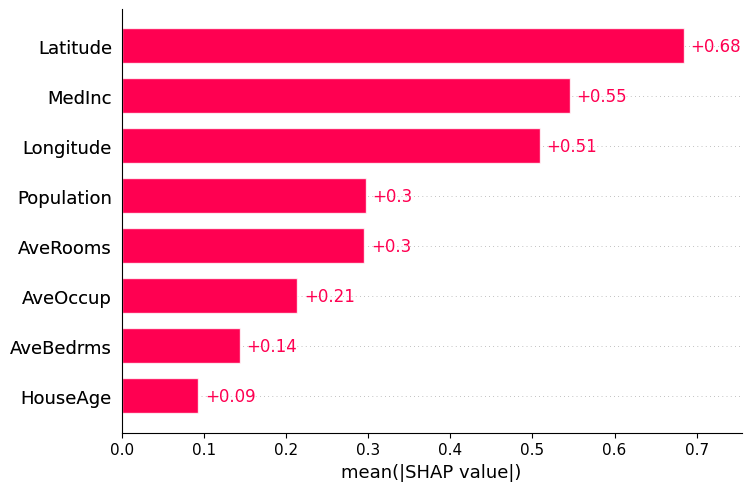

In [12]:
# Feature Importance
lgblss.plot(shap_df,
            parameter="concentration",
            plot_type="Feature_Importance")